In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Load data
def load_data(file_path):
    df = pd.read_csv(file_path)  # Replace with your data path
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' column is datetime
    df = df.sort_values('Date')
    return df

In [ ]:
df = load_data('NDX100_stock.csv')
df

<ipython-input-2-4bab4036ec01>:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' column is datetime


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,3755.739990,3836.860107,3643.250000,3790.550049,1510070000,0.0,0.0
1,2000-01-04 00:00:00-05:00,3766.570068,3766.570068,3542.729980,3546.199951,1511840000,0.0,0.0
2,2000-01-05 00:00:00-05:00,3543.129883,3576.169922,3371.750000,3507.310059,1735670000,0.0,0.0
3,2000-01-06 00:00:00-05:00,3488.310059,3513.550049,3334.020020,3340.810059,1598320000,0.0,0.0
4,2000-01-07 00:00:00-05:00,3337.260010,3529.750000,3314.750000,3529.600098,1634930000,0.0,0.0
...,...,...,...,...,...,...,...,...
6220,2024-09-24 00:00:00-04:00,19917.560547,19984.470703,19739.669922,19944.839844,5347580000,0.0,0.0
6221,2024-09-25 00:00:00-04:00,19922.279297,20043.429688,19921.220703,19972.609375,4858060000,0.0,0.0
6222,2024-09-26 00:00:00-04:00,20273.300781,20273.300781,19966.990234,20115.539062,5669210000,0.0,0.0
6223,2024-09-27 00:00:00-04:00,20147.279297,20152.529297,19964.130859,20008.619141,5367890000,0.0,0.0


In [ ]:
# Prepare data for LSTM
def prepare_data(df, sequence_length=7):
    scaler = MinMaxScaler()
    features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
    scaled_features = scaler.fit_transform(features)

    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i])
        y.append(scaled_features[i, 3])  # Predicting 'Close' price

    X, y = np.array(X), np.array(y)
    return X, y, scaler

In [ ]:
# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only the last time step
        return out

In [ ]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            predictions.extend(outputs.flatten())
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)

In [ ]:
df = pd.read_csv('NDX100_stock.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,3755.739990,3836.860107,3643.25000,3790.550049,1510070000,0.0,0.0
1,2000-01-04 00:00:00-05:00,3766.570068,3766.570068,3542.72998,3546.199951,1511840000,0.0,0.0
2,2000-01-05 00:00:00-05:00,3543.129883,3576.169922,3371.75000,3507.310059,1735670000,0.0,0.0
3,2000-01-06 00:00:00-05:00,3488.310059,3513.550049,3334.02002,3340.810059,1598320000,0.0,0.0
4,2000-01-07 00:00:00-05:00,3337.260010,3529.750000,3314.75000,3529.600098,1634930000,0.0,0.0


<ipython-input-2-4bab4036ec01>:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' column is datetime
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results

Epoch 1/20, Loss: 0.0200
Epoch 2/20, Loss: 0.0345
Epoch 3/20, Loss: 0.0483
Epoch 4/20, Loss: 0.0296
Epoch 5/20, Loss: 0.0240
Epoch 6/20, Loss: 0.0316
Epoch 7/20, Loss: 0.0402
Epoch 8/20, Loss: 0.0224
Epoch 9/20, Loss: 0.0255
Epoch 10/20, Loss: 0.0277
Epoch 11/20, Loss: 0.0411
Epoch 12/20, Loss: 0.0382
Epoch 13/20, Loss: 0.0312
Epoch 14/20, Loss: 0.0161
Epoch 15/20, Loss: 0.0509
Epoch 16/20, Loss: 0.0331
Epoch 17/20, Loss: 0.0626
Epoch 18/20, Loss: 0.0209
Epoch 19/20, Loss: 0.0336
Epoch 20/20, Loss: 0.0363


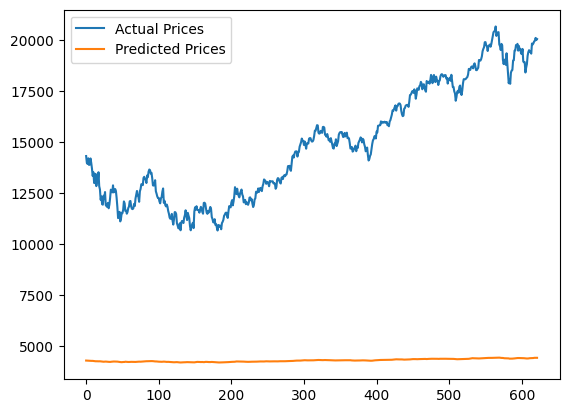

In [ ]:

if __name__ == "__main__":
    # Load and prepare data
    df = load_data('NDX100_stock.csv')  # Replace with your CSV file
    sequence_length = 7
    X, y, scaler = prepare_data(df, sequence_length)

    # Split data
    split_index = int(len(X) * 0.9)
    X_train = X[:split_index]
    X_test = X[split_index:]

    y_train = y[:split_index]
    y_test = y[split_index:]

    # Convert to PyTorch tensors
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                   torch.tensor(y_train, dtype=torch.float32))
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                                  torch.tensor(y_test, dtype=torch.float32))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Define model
    input_dim = X.shape[2]
    hidden_dim = 64
    output_dim = 1
    num_layers = 2
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, device, num_epochs=20)

    # Evaluate the model
    predictions, actuals = evaluate_model(model, test_loader, device)

    # Rescale predictions and actuals
    predictions_rescaled = scaler.inverse_transform(np.zeros((len(predictions), X.shape[2])))
    predictions_rescaled[:, 3] = predictions  # Only update 'Close' column
    predictions_rescaled = scaler.inverse_transform(predictions_rescaled)[:, 3]

    actuals_rescaled = scaler.inverse_transform(np.zeros((len(actuals), X.shape[2])))
    actuals_rescaled[:, 3] = actuals
    actuals_rescaled = scaler.inverse_transform(actuals_rescaled)[:, 3]

    # Plot results
    plt.plot(actuals_rescaled, label='Actual Prices')
    plt.plot(predictions_rescaled, label='Predicted Prices')
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
sp500_df = pd.read_csv('SP500_stock.csv')
sp500_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
1,2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2,2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
3,2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
4,2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0
...,...,...,...,...,...,...,...,...
6220,2024-09-24 00:00:00-04:00,5727.660156,5735.319824,5698.990234,5732.930176,3872710000,0.0,0.0
6221,2024-09-25 00:00:00-04:00,5733.649902,5741.029785,5712.060059,5722.259766,3624910000,0.0,0.0
6222,2024-09-26 00:00:00-04:00,5762.220215,5767.370117,5721.009766,5745.370117,4391180000,0.0,0.0
6223,2024-09-27 00:00:00-04:00,5755.359863,5763.779785,5727.339844,5738.169922,3898530000,0.0,0.0


In [ ]:
sp500_df = sp500_df.dropna()
sp500_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
1,2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2,2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
3,2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
4,2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0
...,...,...,...,...,...,...,...,...
6220,2024-09-24 00:00:00-04:00,5727.660156,5735.319824,5698.990234,5732.930176,3872710000,0.0,0.0
6221,2024-09-25 00:00:00-04:00,5733.649902,5741.029785,5712.060059,5722.259766,3624910000,0.0,0.0
6222,2024-09-26 00:00:00-04:00,5762.220215,5767.370117,5721.009766,5745.370117,4391180000,0.0,0.0
6223,2024-09-27 00:00:00-04:00,5755.359863,5763.779785,5727.339844,5738.169922,3898530000,0.0,0.0


In [ ]:
sp500_df = sp500_df[['Date', 'Close']]
sp500_df

,Date,Close
0,2000-01-03 00:00:00-05:00,1455.219971
1,2000-01-04 00:00:00-05:00,1399.420044
2,2000-01-05 00:00:00-05:00,1402.109985
3,2000-01-06 00:00:00-05:00,1403.449951
4,2000-01-07 00:00:00-05:00,1441.469971
...,...,...
6220,2024-09-24 00:00:00-04:00,5732.930176
6221,2024-09-25 00:00:00-04:00,5722.259766
6222,2024-09-26 00:00:00-04:00,5745.370117
6223,2024-09-27 00:00:00-04:00,5738.169922


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-47-77d8a80cb388>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
<ipython-input-47-77d8a80cb388>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])


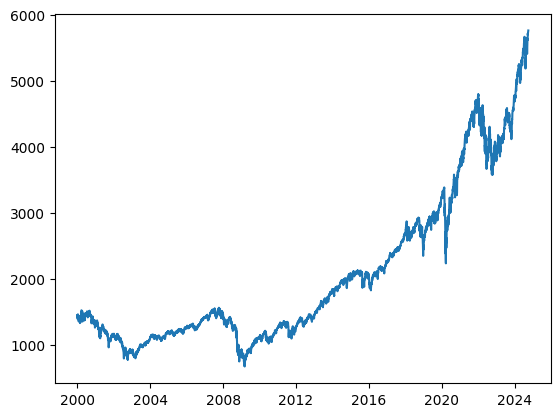

In [ ]:
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])

plt.plot(sp500_df['Date'], sp500_df['Close'])

In [ ]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_sp500_df = prepare_dataframe_for_lstm(sp500_df, lookback)
shifted_sp500_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-01-12 00:00:00-05:00,1432.250000,1438.560059,1457.599976,1441.469971,1403.449951,1402.109985,1399.420044,1455.219971
2000-01-13 00:00:00-05:00,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971,1403.449951,1402.109985,1399.420044
2000-01-14 00:00:00-05:00,1465.150024,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971,1403.449951,1402.109985
2000-01-18 00:00:00-05:00,1455.140015,1465.150024,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971,1403.449951
2000-01-19 00:00:00-05:00,1455.900024,1455.140015,1465.150024,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971
...,...,...,...,...,...,...,...,...
2024-09-24 00:00:00-04:00,5732.930176,5718.569824,5702.549805,5713.640137,5618.259766,5634.580078,5633.089844,5626.020020
2024-09-25 00:00:00-04:00,5722.259766,5732.930176,5718.569824,5702.549805,5713.640137,5618.259766,5634.580078,5633.089844
2024-09-26 00:00:00-04:00,5745.370117,5722.259766,5732.930176,5718.569824,5702.549805,5713.640137,5618.259766,5634.580078


In [ ]:
shifted_sp500_df_as_np = shifted_sp500_df.to_numpy()

shifted_sp500_df_as_np

array([[1432.25      , 1438.56005859, 1457.59997559, ..., 1402.10998535,
        1399.42004395, 1455.2199707 ],
       [1449.68005371, 1432.25      , 1438.56005859, ..., 1403.44995117,
        1402.10998535, 1399.42004395],
       [1465.15002441, 1449.68005371, 1432.25      , ..., 1441.4699707 ,
        1403.44995117, 1402.10998535],
       ...,
       [5745.37011719, 5722.25976562, 5732.93017578, ..., 5713.64013672,
        5618.25976562, 5634.58007812],
       [5738.16992188, 5745.37011719, 5722.25976562, ..., 5702.54980469,
        5713.64013672, 5618.25976562],
       [5762.47998047, 5738.16992188, 5745.37011719, ..., 5718.56982422,
        5702.54980469, 5713.64013672]])

In [ ]:
shifted_sp500_df_as_np.shape

(6218, 8)

In [ ]:
X = shifted_sp500_df_as_np[:, 1:]
y = shifted_sp500_df_as_np[:, 0]

X.shape, y.shape

((6218, 7), (6218,))

In [ ]:
X = dc(np.flip(X, axis=1))
X

array([[1455.2199707 , 1399.42004395, 1402.10998535, ..., 1441.4699707 ,
        1457.59997559, 1438.56005859],
       [1399.42004395, 1402.10998535, 1403.44995117, ..., 1457.59997559,
        1438.56005859, 1432.25      ],
       [1402.10998535, 1403.44995117, 1441.4699707 , ..., 1438.56005859,
        1432.25      , 1449.68005371],
       ...,
       [5634.58007812, 5618.25976562, 5713.64013672, ..., 5718.56982422,
        5732.93017578, 5722.25976562],
       [5618.25976562, 5713.64013672, 5702.54980469, ..., 5732.93017578,
        5722.25976562, 5745.37011719],
       [5713.64013672, 5702.54980469, 5718.56982422, ..., 5722.25976562,
        5745.37011719, 5738.16992188]])

In [ ]:
split_index = int(len(X) * 0.95)

split_index

5907

In [ ]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5907, 7), (311, 7), (5907,), (311,))

In [ ]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5907, 7, 1), (311, 7, 1), (5907, 1), (311, 1))

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5907, 7, 1]),
 torch.Size([311, 7, 1]),
 torch.Size([5907, 1]),
 torch.Size([311, 1]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
train_dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
learning_rate = 0.01
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 4364123.989
Batch 200, Loss: 4132324.031
Batch 300, Loss: 4280546.060

Val Loss: 23661229.600
***************************************************

Epoch: 2
Batch 100, Loss: 4359941.745
Batch 200, Loss: 4130527.810
Batch 300, Loss: 4163239.519

Val Loss: 23625769.600
***************************************************

Epoch: 3
Batch 100, Loss: 4271164.657
Batch 200, Loss: 4104913.815
Batch 300, Loss: 4244787.066

Val Loss: 23590351.200
***************************************************

Epoch: 4
Batch 100, Loss: 4171661.110
Batch 200, Loss: 4231584.349
Batch 300, Loss: 4038820.368

Val Loss: 23555030.400
***************************************************

Epoch: 5
Batch 100, Loss: 4110607.640
Batch 200, Loss: 4323883.994
Batch 300, Loss: 4231788.301

Val Loss: 23519771.800
***************************************************

Epoch: 6
Batch 100, Loss: 4399952.021
Batch 200, Loss: 4161765.776
Batch 300, Loss: 4038295.404

Val Loss: 23484549.400
***************

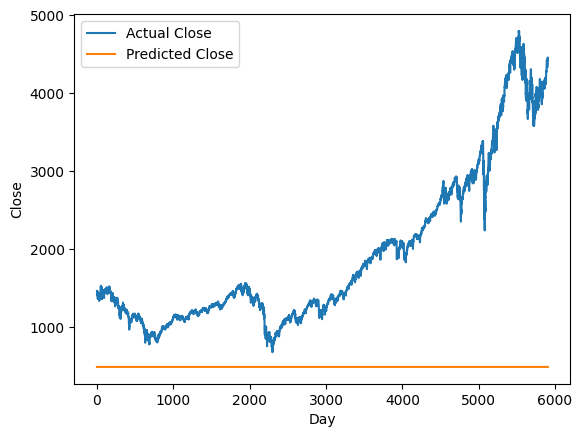

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
# Date: The date of the record.
# Open: Opening price of the stock.
# High: Highest price of the stock on that day.
# Low: Lowest price of the stock on that day.
# Close: Closing price of the stock (target for prediction).
# Volume:s The volume of stocks traded.
# Dividends: Dividends paid (if any).
# Stock Splits: Stock split information.

# Training Data:
# Features: (4956, 30, 4)(4956,30,4) (4956 sequences, 30 days each, 4 features per day)
# Target: (4956,)(4956,)
# Test Data:

# Features: (1239, 30, 4)(1239,30,4)
# Target: (1239,)(1239,)

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Load and preprocess the data
data = pd.read_csv("NDX100_stock.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# # sort the data by date
# df['Date'] = pd.to_datetime(df['Date'])
# df.sort_values(by='Date', inplace=True)

# Create the target column for next day's Close price
data['Next_Day_Close'] = data['Close'].shift(-1)

# Drop the last row as it doesn't have a target
data = data[:-1]

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',	'Stock Splits']
target = 'Next_Day_Close'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])

# # Features and Target
# X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
# y = df['Next_Day_Close']  # Target is next day's Close price

# # Split data into training and testing sets
# split_index = int(len(X) * 0.9)
# X_train = X[:split_index]
# X_test = X[split_index:]

# y_train = y[:split_index]
# y_test = y[split_index:]

<ipython-input-25-3f7965402b5b>:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
# Load and preprocess the data
data = pd.read_csv("NDX100_stock.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])

<ipython-input-2-85b99b8538b4>:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length, :-1])
        targets.append(data[i + seq_length, -1])
    return np.array(sequences), np.array(targets)

In [ ]:
class StockPricePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockPricePredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        hn = hn[-1]
        return self.fc(hn)

In [ ]:
seq_length = 30
sequences, targets = create_sequences(scaled_data, seq_length)

split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)
X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = targets[:split_index], targets[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

model = StockPricePredictor(input_dim=7, hidden_dim=64, num_layers=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/20, Loss: 0.0027
Epoch 2/20, Loss: 0.0000
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Test Loss: 0.0050


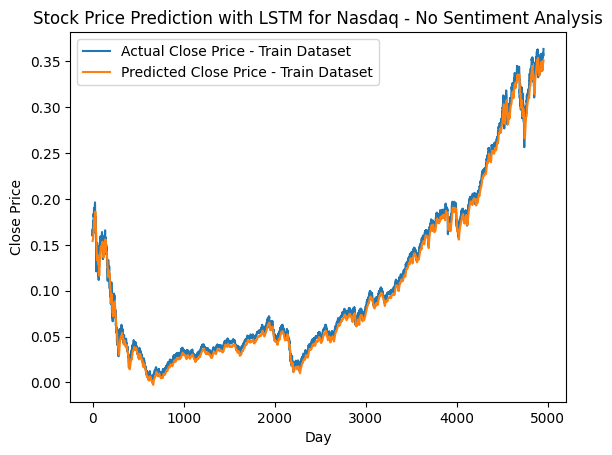

In [ ]:
with torch.no_grad():
    predicted = model(X_train_tensor.to(device)).to('cpu').numpy()

plt.plot(y_train_tensor, label='Actual Close Price - Train Dataset')
plt.plot(predicted, label='Predicted Close Price - Train Dataset')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction with LSTM for Nasdaq - No Sentiment Analysis')
plt.legend()
plt.show()

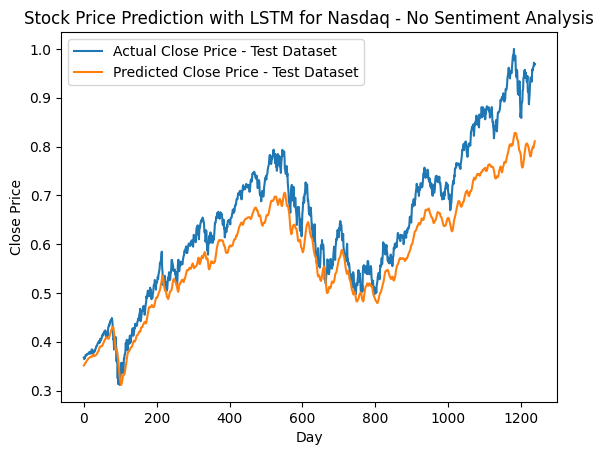

In [ ]:
with torch.no_grad():
    predicted = model(X_test_tensor.to(device)).to('cpu').numpy()

plt.plot(y_test_tensor, label='Actual Close Price - Test Dataset')
plt.plot(predicted, label='Predicted Close Price - Test Dataset')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction with LSTM for Nasdaq - No Sentiment Analysis')
plt.legend()
plt.show()

In [ ]:
# Load and preprocess the data
data = pd.read_csv("SP500_stock.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# # sort the data by date
# df['Date'] = pd.to_datetime(df['Date'])
# df.sort_values(by='Date', inplace=True)

# Create the target column for next day's Close price
data['Next_Day_Close'] = data['Close'].shift(-1)

# Drop the last row as it doesn't have a target
data = data[:-1]

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',	'Stock Splits']
target = 'Next_Day_Close'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])

<ipython-input-29-b5b9bb45eeed>:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
seq_length = 30
sequences, targets = create_sequences(scaled_data, seq_length)

split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)
X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = targets[:split_index], targets[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

model = StockPricePredictor(input_dim=7, hidden_dim=64, num_layers=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/20, Loss: 0.0040
Epoch 2/20, Loss: 0.0000
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0001
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Test Loss: 0.0007


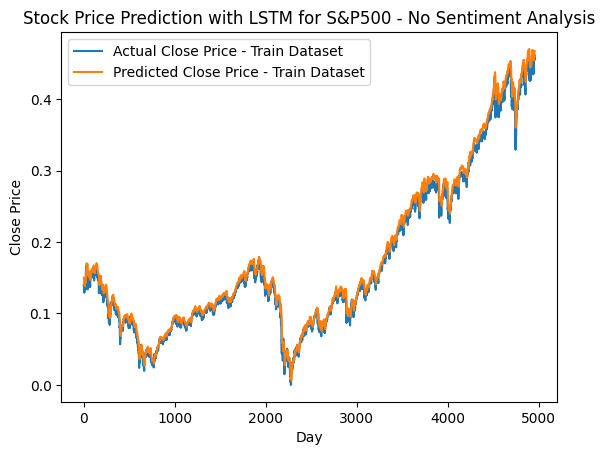

In [ ]:
with torch.no_grad():
    predicted = model(X_train_tensor.to(device)).to('cpu').numpy()

plt.plot(y_train_tensor, label='Actual Close Price - Train Dataset')
plt.plot(predicted, label='Predicted Close Price - Train Dataset')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction with LSTM for S&P500 - No Sentiment Analysis')
plt.legend()
plt.show()

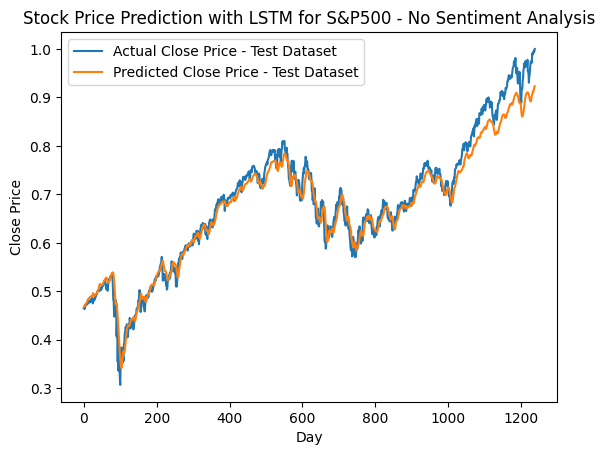

In [ ]:
with torch.no_grad():
    predicted = model(X_test_tensor.to(device)).to('cpu').numpy()

plt.plot(y_test_tensor, label='Actual Close Price - Test Dataset')
plt.plot(predicted, label='Predicted Close Price - Test Dataset')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction with LSTM for S&P500 - No Sentiment Analysis')
plt.legend()
plt.show()